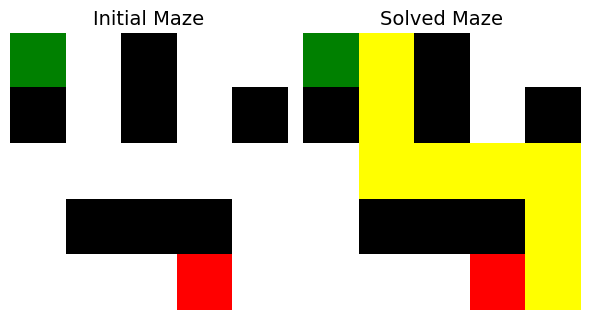

In [ ]:
from typing import List, Tuple
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import heapq
import itertools  # For a unique counter to avoid heap comparison issues

# ------------------------------------------------------------
# CONSTANTS
# ------------------------------------------------------------
BLANK_SPACE_ID = 0   # Walkable space
WALL_SPACE_ID = 1    # Wall/block
START_SPACE_ID = 2   # Start point
END_SPACE_ID = 3     # End/goal point
SOLUTION_SPACE_ID = 4  # Path found by the algorithm

# Direction markers (used to track the direction from which a cell was reached)
PREV_UP_ID = -1
PREV_DOWN_ID = -2
PREV_LEFT_ID = -3
PREV_RIGHT_ID = -4


# ------------------------------------------------------------
# HELPER FUNCTIONS
# ------------------------------------------------------------
def find_maze_space(maze: List[List[int]], space_id: int) -> Tuple[int, int]:
    """
    Find coordinates of the first occurrence of a given space_id in the maze.
    Returns (x, y) or (-1, -1) if not found.
    """
    for y in range(len(maze)):
        for x in range(len(maze[y])):
            if maze[y][x] == space_id:
                return x, y
    return -1, -1


def check_wasd(
    maze: List[List[int]],
    x_cord: int,
    y_cord: int,
    valid_ids: List[int] = [BLANK_SPACE_ID, END_SPACE_ID],
) -> tuple[bool, bool, bool, bool]:
    """
    Check the four directions (North, South, East, West) for valid moves.
    Returns four boolean flags: north_check, south_check, east_check, west_check
    """
    north_check = False if y_cord == 0 else (maze[y_cord - 1][x_cord] in valid_ids)
    south_check = False if y_cord == len(maze) - 1 else (maze[y_cord + 1][x_cord] in valid_ids)
    east_check = False if x_cord == len(maze[y_cord]) - 1 else (maze[y_cord][x_cord + 1] in valid_ids)
    west_check = False if x_cord == 0 else (maze[y_cord][x_cord - 1] in valid_ids)
    return north_check, south_check, east_check, west_check


def manhattan_dist(x1, y1, x2, y2):
    """
    Compute Manhattan distance between two points (x1, y1) and (x2, y2).
    Used as a heuristic to guide the goal-based search.
    """
    return abs(x1 - x2) + abs(y1 - y2)


# ------------------------------------------------------------
# GOAL-BASED MAZE SOLVER
# ------------------------------------------------------------
def solve_maze_goal_based(
    maze: List[List[int]],
    start_space_id: int = START_SPACE_ID,
    end_space_id: int = END_SPACE_ID,
    prev_up_id: int = PREV_UP_ID,
    prev_down_id: int = PREV_DOWN_ID,
    prev_left_id: int = PREV_LEFT_ID,
    prev_right_id: int = PREV_RIGHT_ID,
    history: bool = False,
) -> List[List[List[int]]]:
    """
    Solve the maze using a goal-based search (Greedy Best-First Search).
    Returns a list of maze states if history=True, otherwise just the final solved maze.
    """
    # Step 1: Find start and end positions
    start_x, start_y = find_maze_space(maze, start_space_id)
    end_x, end_y = find_maze_space(maze, end_space_id)

    # Return original maze if start or end not found
    if start_x == -1 or start_y == -1 or end_x == -1 or end_y == -1:
        return [maze]

    # Step 2: Initialize priority queue with heuristic
    open_set = []  # Priority queue for goal-based exploration
    counter = itertools.count()  # Unique counter to avoid dict comparison issues in heapq
    heapq.heappush(
        open_set,
        (manhattan_dist(start_x, start_y, end_x, end_y), next(counter), {"x": start_x, "y": start_y})
    )

    active_maze = deepcopy(maze)  # Maze used for exploration
    solved_maze = deepcopy(maze)  # Maze used to store the final solution path
    history_maze = []              # Stores the maze states for visualization if needed
    winning_tile = {}              # Will store the tile from which we reached the goal

    # Step 3: Goal-based search loop
    while open_set and not winning_tile:
        # Pop the tile with the smallest heuristic distance to goal
        _, _, tile = heapq.heappop(open_set)

        # Store maze state for visualization
        if history:
            history_maze.append(deepcopy(active_maze))

        x, y = tile["x"], tile["y"]
        north, south, east, west = check_wasd(active_maze, x, y)

        # Step 3a: Prepare neighbors for exploration
        neighbors = []
        if north:
            neighbors.append((x, y - 1, prev_down_id))
        if south:
            neighbors.append((x, y + 1, prev_up_id))
        if east:
            neighbors.append((x + 1, y, prev_left_id))
        if west:
            neighbors.append((x - 1, y, prev_right_id))

        # Step 3b: Explore neighbors
        for nx, ny, marker in neighbors:
            # Check if neighbor is the goal
            if nx == end_x and ny == end_y:
                winning_tile = {"x": x, "y": y}

            # If neighbor is walkable, mark direction and add to priority queue
            if active_maze[ny][nx] in [BLANK_SPACE_ID]:
                active_maze[ny][nx] = marker
                heapq.heappush(
                    open_set,
                    (manhattan_dist(nx, ny, end_x, end_y), next(counter), {"x": nx, "y": ny})
                )

    # Step 4: Backtrack to mark solution path
    if winning_tile:
        cx, cy = winning_tile["x"], winning_tile["y"]
        while maze[cy][cx] != START_SPACE_ID:
            solved_maze[cy][cx] = SOLUTION_SPACE_ID
            if active_maze[cy][cx] == prev_up_id:
                cy -= 1
            elif active_maze[cy][cx] == prev_down_id:
                cy += 1
            elif active_maze[cy][cx] == prev_left_id:
                cx -= 1
            elif active_maze[cy][cx] == prev_right_id:
                cx += 1
        history_maze.append(deepcopy(solved_maze))

    return history_maze


# ------------------------------------------------------------
# VISUALIZATION
# ------------------------------------------------------------
def visualize_maze(maze_history: List[List[List[int]]]):
    """
    Visualize the maze using matplotlib.
    Shows initial and solved maze side by side.
    Color map:
        White: Blank
        Black: Wall
        Green: Start
        Red: Goal
        Yellow: Solution path
    """
    cmap = mcolors.ListedColormap(["white", "black", "green", "red", "yellow"])
    bounds = [-4.5, 0.5, 1.5, 2.5, 3.5, 4.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(6, 6))
    for i, maze in enumerate([maze_history[0], maze_history[-1]]):
        plt.subplot(1, 2, i + 1)
        title = "Initial Maze" if i == 0 else "Solved Maze"
        plt.title(title, fontsize=14)
        plt.imshow(maze, cmap=cmap, norm=norm)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------
# MAIN EXECUTION
# ------------------------------------------------------------
if __name__ == "__main__":
    # Example maze (2=start, 3=end, 1=wall, 0=blank)
    maze = [
        [2, 0, 1, 0, 0],
        [1, 0, 1, 0, 1],
        [0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0],
        [0, 0, 0, 3, 0],
    ]

    # Solve maze using goal-based search
    maze_history = solve_maze_goal_based(maze, history=True)

    # Visualize initial and solved maze
    visualize_maze(maze_history)
